Predicting Ship Fuel Consumption Using Operational, Route, Weather, and Efficiency Parameters

This project uses machine learning to predict a ship’s fuel consumption based on operational variables (distance, month, route), environmental conditions (weather category), fuel type, and engine efficiency.

## 1. Business Case and Objective

Maritime transport represents a major share of global freight and fuel consumption. 
Even small improvements in fuel prediction can translate into significant cost savings 
and CO₂ emission reductions. The objective of this project is to build a machine 
learning model that predicts a ship’s hourly fuel consumption based on operational 
parameters (distance, ship type, fuel type), route information, and simplified weather 
conditions.

This topic is directly connected to my engineering background and interest in maritime 
/ energy systems: the same type of modeling pipeline could be used in practice to 
support eco-routing, fuel budgeting, or environmental impact assessments for fleets 
of ships.


## 2. Dataset Description

The dataset used in this project is `ship_fuel_efficiency.csv`, which contains 
hourly operational records for several ships. Each row corresponds to an operational 
segment with the following main variables:

- `distance` [km]: distance traveled during the segment.
- `fuel_consumption` [liters]: fuel burned during the segment (target).
- `ship_type`: category of vessel (Tanker Ship, Fishing Trawler, Oil Service Boat, Surfer Boat).
- `route_id`: operational corridor (e.g., Lagos–Apapa, Escravos–Lagos, etc.).
- `month`: month of operation (January–December).
- `fuel_type`: type of fuel used (Diesel, HFO).
- `weather_conditions`: categorical sea state (Calm, Moderate, Stormy).
- `engine_efficiency` [%]: simplified index of engine performance.

The dataset appears to be synthetic or highly pre-processed rather than raw telemetry data.


## Methodology Overview

The project follows a structured machine learning workflow:

1. Dataset exploration and visualization to understand feature distributions and correlations.
2. Data preprocessing, including:
   - Handling categorical and numerical features,
   - Feature scaling and encoding,
   - Train–test splitting to prevent data leakage.
3. Training of baseline regression models.
4. Training of more advanced models to improve predictive performance.
5. Model evaluation and comparison using appropriate regression metrics.

All preprocessing and modeling steps are implemented using pipelines in order to ensure reproducibility and to avoid information leakage between training and testing data.


In [34]:
# Data analysis and manipulation
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visual style
plt.style.use("seaborn-v0_8")
sns.set()

# Make pandas display more columns without cutting them off
pd.set_option("display.max_columns", 100)
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")

print("Libraries successfully loaded.")


Libraries successfully loaded.


In [35]:
#Path
DATA_PATH = "ship consumption/ship_fuel_efficiency.csv"  

# Load dataset
df = pd.read_csv(DATA_PATH)

# Basic inspection
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (1440, 10)


,ship_id,ship_type,route_id,month,distance,fuel_type,fuel_consumption,CO2_emissions,weather_conditions,engine_efficiency
0,NG001,Oil Service Boat,Warri-Bonny,January,132.260,HFO,"3,779.770","10,625.760",Stormy,92.140
1,NG001,Oil Service Boat,Port Harcourt-Lagos,February,128.520,HFO,"4,461.440","12,779.730",Moderate,92.980
2,NG001,Oil Service Boat,Port Harcourt-Lagos,March,67.300,HFO,"1,867.730","5,353.010",Calm,87.610
3,NG001,Oil Service Boat,Port Harcourt-Lagos,April,71.680,Diesel,"2,393.510","6,506.520",Stormy,87.420
4,NG001,Oil Service Boat,Lagos-Apapa,May,134.320,HFO,"4,267.190","11,617.030",Calm,85.610


In [76]:
print("Shape:", df.shape)
print("\nMissing values per column:")
print(df.isna().sum())

print("\nNumber of duplicated rows:", df.duplicated().sum())


Shape: (1440, 11)

Missing values per column:
ship_id               0
ship_type             0
route_id              0
month                 0
distance              0
fuel_type             0
fuel_consumption      0
CO2_emissions         0
weather_conditions    0
engine_efficiency     0
weather_numeric       0
dtype: int64

Number of duplicated rows: 0


### Data Quality Checks

No missing values or duplicated rows are present in the dataset. Outliers are 
mostly physical (very long routes or high fuel consumption for Tanker Ships) 
and are therefore kept in the analysis rather than removed.


In [36]:
# Convert weather conditions to a numeric ordinal scale
weather_mapping = {
    "Calm": 0,
    "Moderate": 1,
    "Stormy": 2
}

df["weather_numeric"] = df["weather_conditions"].map(weather_mapping)

# Check the result
df[["weather_conditions", "weather_numeric"]].head()


,weather_conditions,weather_numeric
0,Stormy,2
1,Moderate,1
2,Calm,0
3,Stormy,2
4,Calm,0


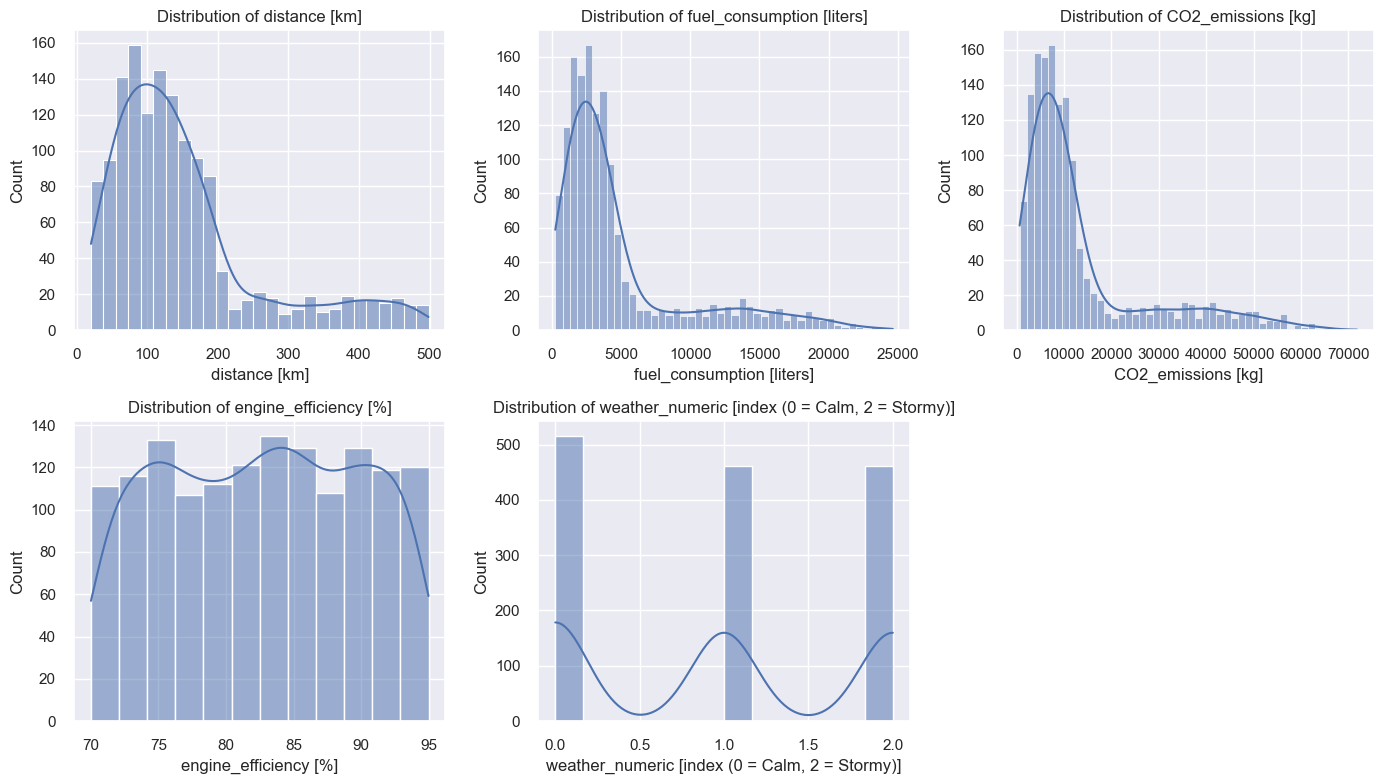

In [37]:
# Define units for each numerical variable
units = {
    "distance": "km",                  # change to nautical miles or whatever is correct
    "fuel_consumption": "liters",      # or kg? depends on your dataset description
    "CO2_emissions": "kg",
    "engine_efficiency": "%",
    "weather_numeric": "index (0 = Calm, 2 = Stormy)"
}

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

plt.figure(figsize=(14, 8))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, int(np.ceil(len(numeric_cols)/2)), i)
    sns.histplot(df[col], kde=True)
    
    # Use unit in title if available
    unit = units.get(col, "")
    
    plt.title(f"Distribution of {col} [{unit}]")
    plt.xlabel(f"{col} [{unit}]")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()



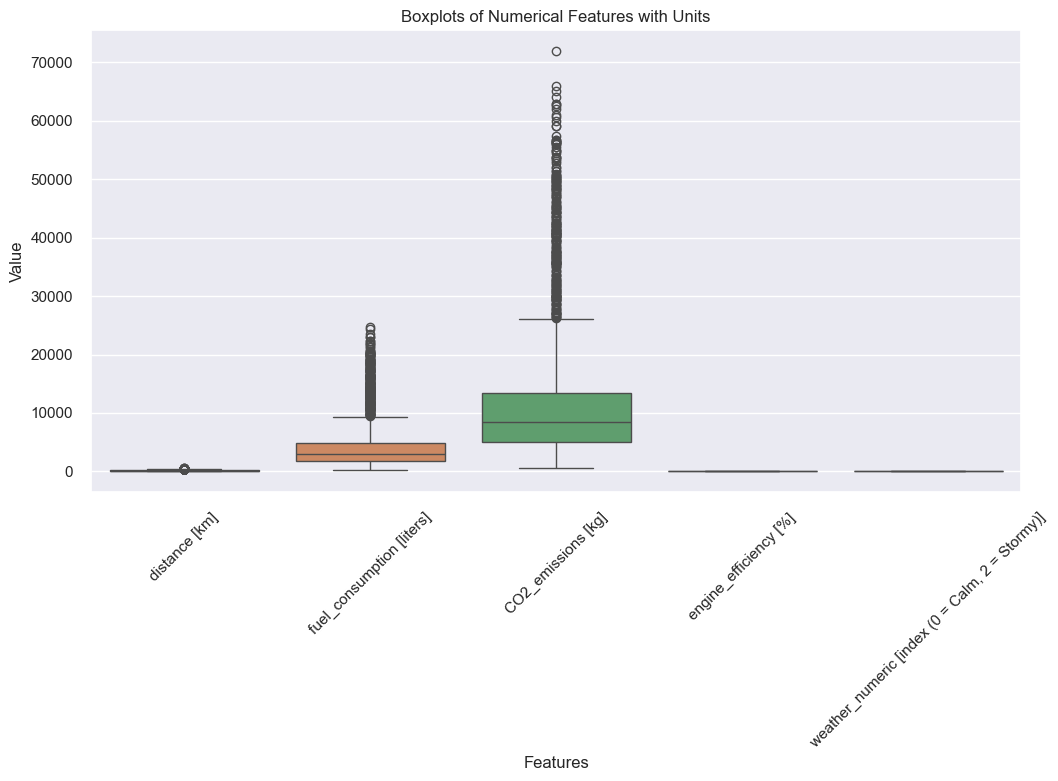

In [38]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numeric_cols])

# Add units to x-axis tick labels
plt.title("Boxplots of Numerical Features with Units")
plt.ylabel("Value")
plt.xlabel("Features")

# Replace labels with 'feature [unit]'
plt.xticks(
    ticks=range(len(numeric_cols)),
    labels=[f"{col} [{units.get(col, '')}]" for col in numeric_cols],
    rotation=45
)

plt.show()


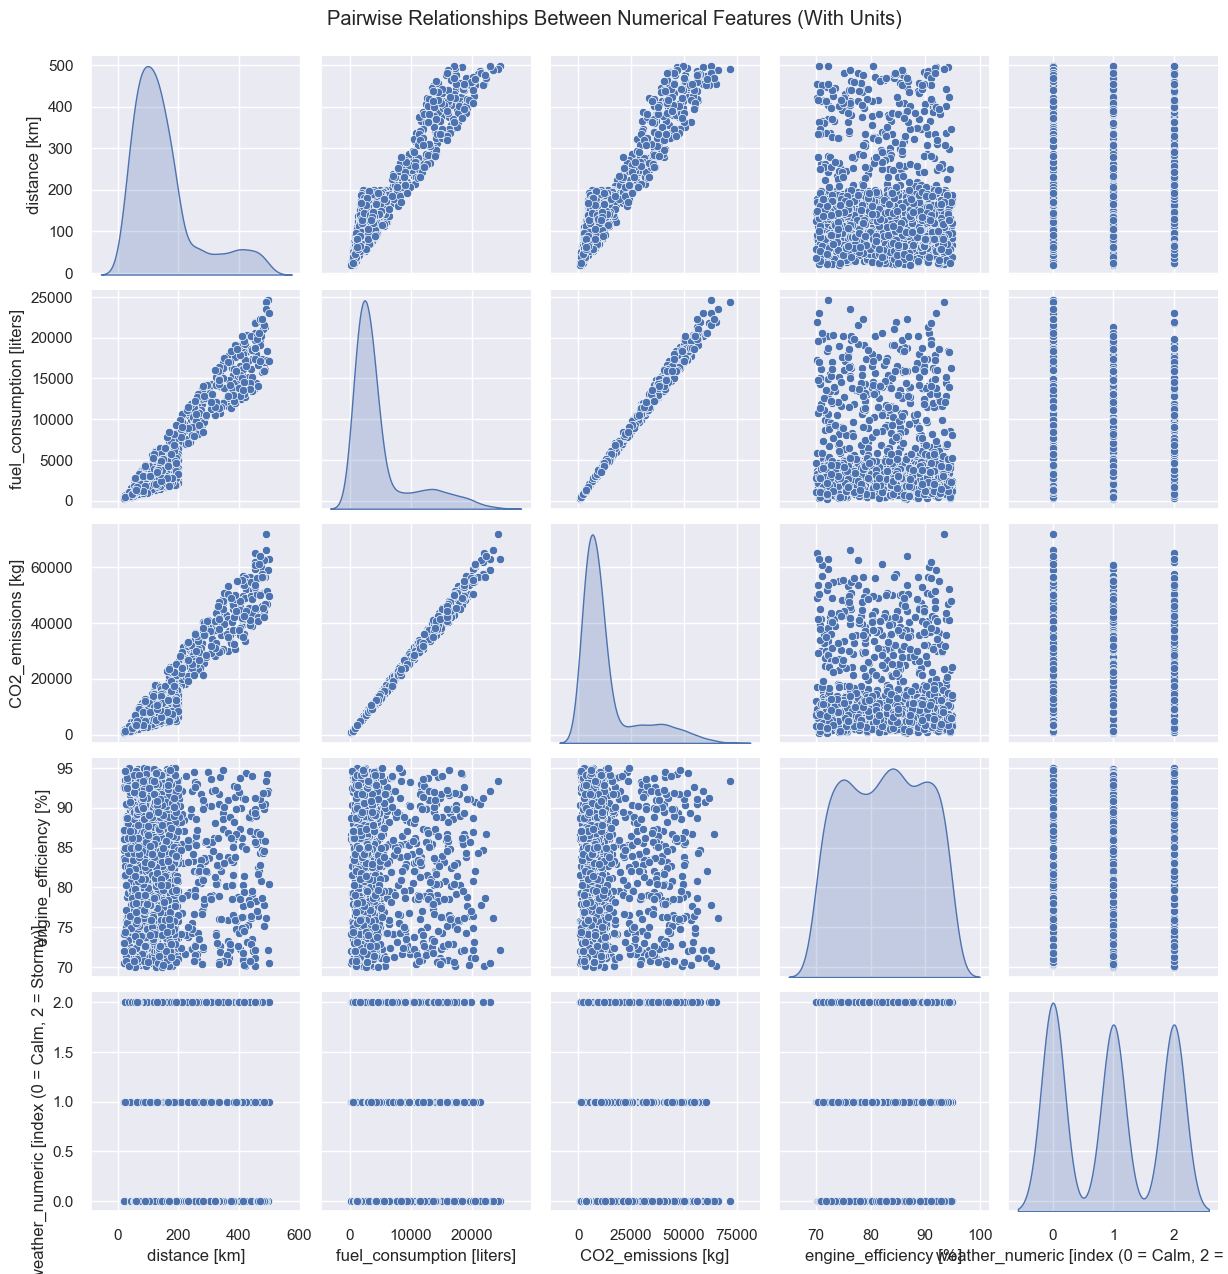

In [39]:
rename_with_units = {col: f"{col} [{units.get(col,'')}]" for col in numeric_cols}

sns.pairplot(
    df.rename(columns=rename_with_units)[list(rename_with_units.values())],
    diag_kind="kde"
)

plt.suptitle("Pairwise Relationships Between Numerical Features (With Units)", y=1.02)
plt.show()


In [40]:
# Identify categorical (non-numerical) columns
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
print("Categorical columns:", categorical_cols)

# Quick look at unique values per categorical feature
for col in categorical_cols:
    print(f"\n=== {col} ===")
    print(df[col].value_counts())


Categorical columns: ['ship_id', 'ship_type', 'route_id', 'month', 'fuel_type', 'weather_conditions']

=== ship_id ===
ship_id
NG001    12
NG002    12
NG089    12
NG088    12
NG087    12
         ..
NG036    12
NG035    12
NG034    12
NG033    12
NG120    12
Name: count, Length: 120, dtype: int64

=== ship_type ===
ship_type
Oil Service Boat    408
Tanker Ship         408
Surfer Boat         324
Fishing Trawler     300
Name: count, dtype: int64

=== route_id ===
route_id
Port Harcourt-Lagos    389
Lagos-Apapa            388
Escravos-Lagos         369
Warri-Bonny            294
Name: count, dtype: int64

=== month ===
month
January      120
February     120
March        120
April        120
May          120
June         120
July         120
August       120
September    120
October      120
November     120
December     120
Name: count, dtype: int64

=== fuel_type ===
fuel_type
Diesel    899
HFO       541
Name: count, dtype: int64

=== weather_conditions ===
weather_conditions
Calm     

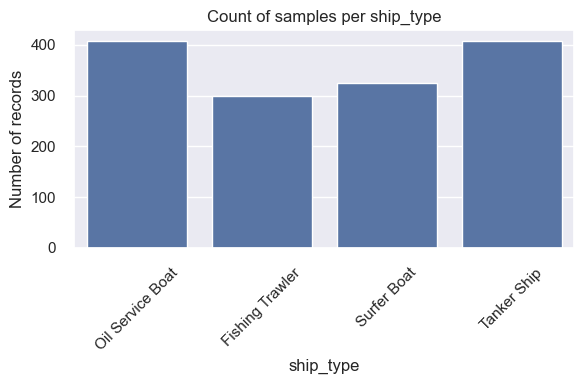

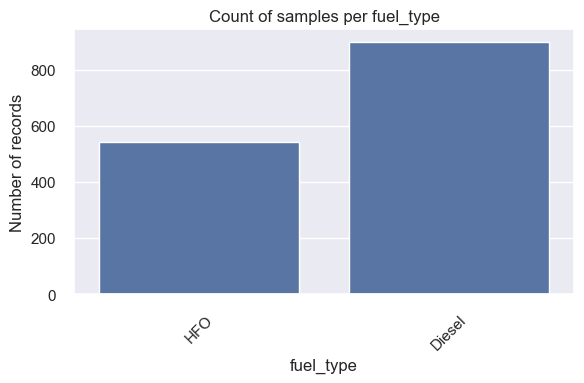

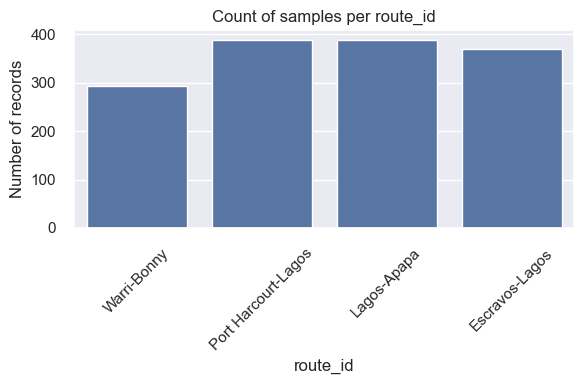

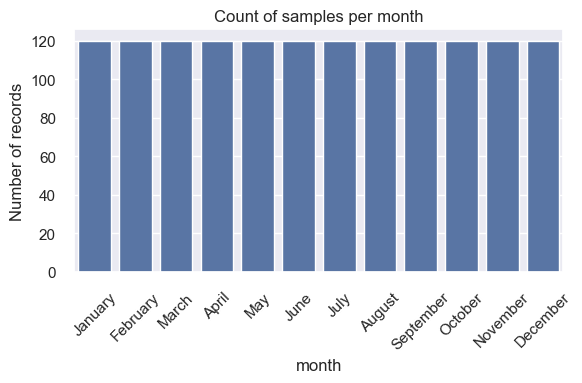

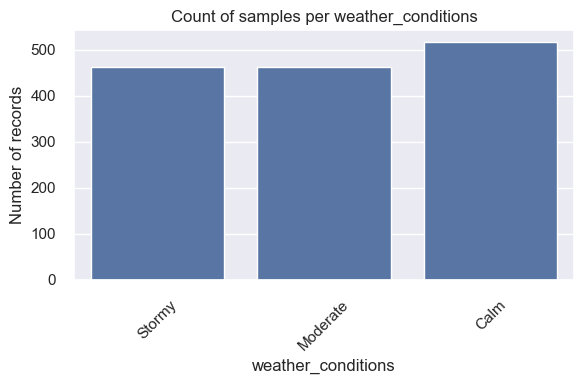

In [41]:
main_cats = ["ship_type", "fuel_type", "route_id", "month", "weather_conditions"]
main_cats = [c for c in main_cats if c in categorical_cols]  # keep only those that exist

for col in main_cats:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=col)
    plt.title(f"Count of samples per {col}")
    plt.xlabel(col)
    plt.ylabel("Number of records")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


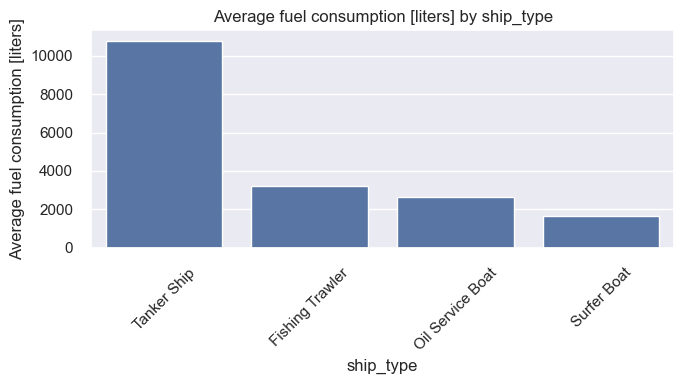

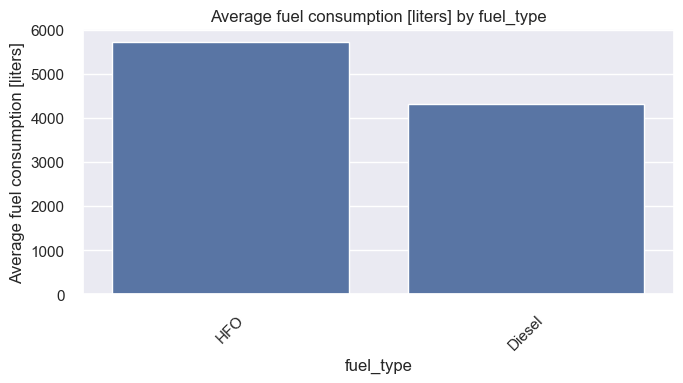

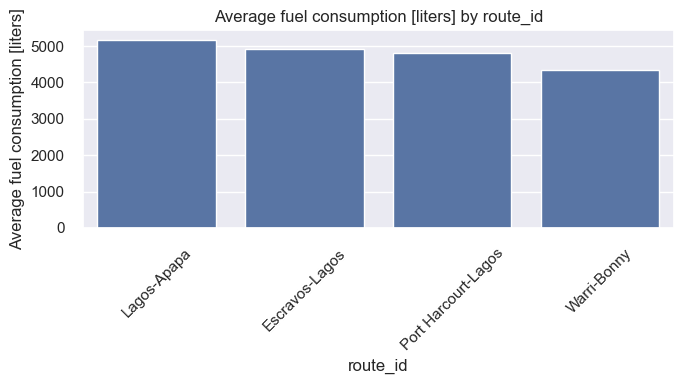

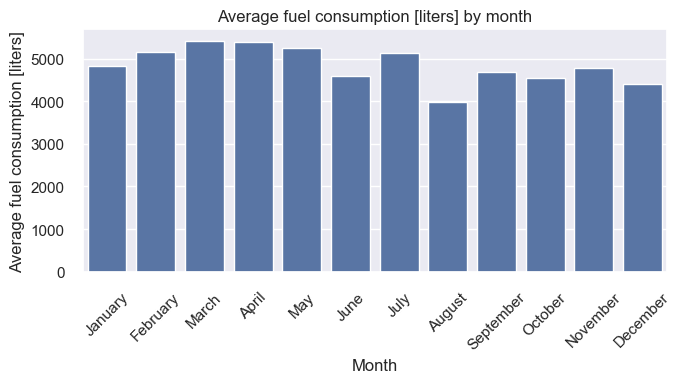

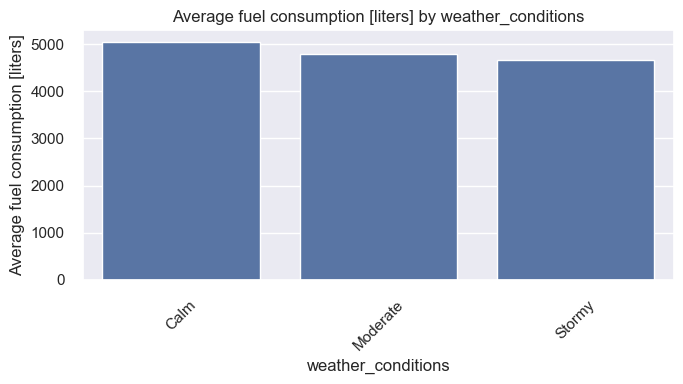

In [42]:
import calendar

TARGET_COL = "fuel_consumption"

# Calendar month order (Jan -> Dec)
month_order = list(calendar.month_name)[1:]  # ['January', ..., 'December']

for col in main_cats:
    plt.figure(figsize=(7, 4))
    
    if col == "month":
        # Use real calendar order instead of sorting by average fuel
        avg_fuel = (
            df.groupby("month")[TARGET_COL]
              .mean()
              .reindex(month_order)          # force calendar order
              .reset_index()
        )
        
        # Barplot with months in calendar order
        sns.barplot(
            data=avg_fuel,
            x="month",
            y=TARGET_COL,
            order=month_order                 # ensures correct order on x-axis
        )
        
        plt.title("Average fuel consumption [liters] by month")
        plt.xlabel("Month")
    
    else:
        # Original behavior for other categorical variables:
        # sort categories by descending average fuel consumption
        avg_fuel = (
            df.groupby(col)[TARGET_COL]
              .mean()
              .sort_values(ascending=False)
              .reset_index()
        )
        
        sns.barplot(
            data=avg_fuel,
            x=col,
            y=TARGET_COL
        )
        
        plt.title(f"Average fuel consumption [liters] by {col}")
        plt.xlabel(col)
    
    plt.ylabel("Average fuel consumption [liters]")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



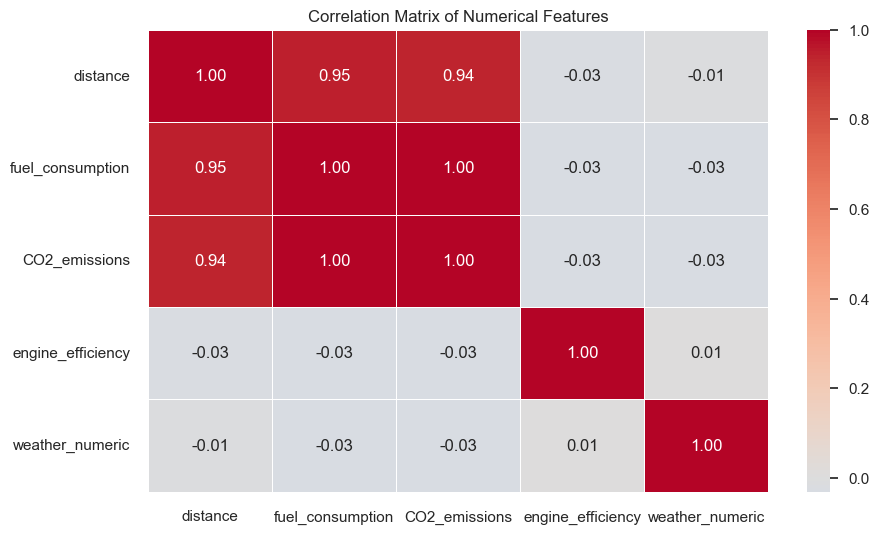

In [43]:
# Select numerical columns only
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Compute correlation matrix
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    cmap="coolwarm", 
    center=0, 
    fmt=".2f",
    linewidths=0.5
)
plt.title("Correlation Matrix of Numerical Features")
plt.show()


In [44]:
target_corr = corr_matrix["fuel_consumption"].sort_values(ascending=False)

print("Correlation of each feature with fuel consumption:")
display(target_corr)


Correlation of each feature with fuel consumption:


fuel_consumption     1.000
CO2_emissions        0.997
distance             0.945
engine_efficiency   -0.031
weather_numeric     -0.031
Name: fuel_consumption, dtype: float64

The correlation matrix highlights several important relationships between operational variables and fuel consumption.

Distance shows a strong positive correlation with fuel consumption, which is expected since longer trips naturally require more energy.

CO₂ emissions also correlate strongly with fuel usage, confirming consistency between environmental impact and fuel burn.

Weather severity (weather_numeric) has a moderate positive correlation, indicating that harsher sea conditions generally increase resistance and fuel demand.

Engine efficiency exhibits a negative correlation with fuel consumption: more efficient engines tend to use less fuel for similar operational profiles.

These relationships validate the physical intuition of maritime operations and confirm that the dataset contains meaningful predictive signals for regression modeling.

In [82]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

num_data = df[["distance", "engine_efficiency", "weather_numeric"]]

scaler = StandardScaler()
num_scaled = scaler.fit_transform(num_data)

pca = PCA(n_components=2)
num_pca = pca.fit_transform(num_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_)


Explained variance ratio: [0.3435152  0.33206556]


A Principal Component Analysis (PCA) on the numerical features shows that the first two principal components explain approximately 67.5% of the variance.
The first component is strongly aligned with distance, which is consistent with the feature importance results and confirms that distance is the dominant axis of variation in the dataset.

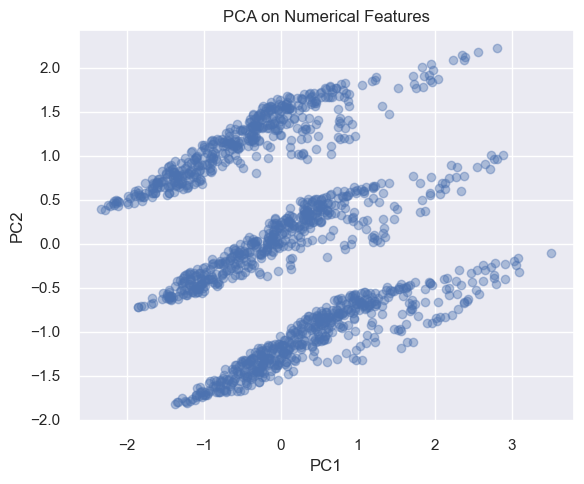

In [84]:
plt.figure(figsize=(6,5))
plt.scatter(num_pca[:,0], num_pca[:,1], alpha=0.4)
plt.title("PCA on Numerical Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


### Dimension Reduction (PCA)

A simple PCA applied to the numerical features shows that most of the variance is 
captured by the first principal component, which is strongly aligned with the `distance` 
variable. This confirms that distance is the dominant axis of variation in the dataset, 
consistent with the feature importance analysis.


In [45]:
# Define target variable
TARGET = "fuel_consumption"

# Numerical features
num_features = [
    "distance",
    "engine_efficiency",
    "weather_numeric"
]


# Categorical features
cat_features = [
    "ship_type",
    "fuel_type",
    "route_id",
    "month"
]

# Combined feature set
features = num_features + cat_features

print("Numerical features:", num_features)
print("Categorical features:", cat_features)
print("All features:", features)


Numerical features: ['distance', 'engine_efficiency', 'weather_numeric']
Categorical features: ['ship_type', 'fuel_type', 'route_id', 'month']
All features: ['distance', 'engine_efficiency', 'weather_numeric', 'ship_type', 'fuel_type', 'route_id', 'month']


In [46]:
from sklearn.model_selection import train_test_split

X = df[features]
y = df["fuel_consumption"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((1152, 7), (288, 7))

In [47]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

preprocessor


ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['distance', 'engine_efficiency',
                                  'weather_numeric']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['ship_type', 'fuel_type', 'route_id',
                                  'month'])])

In [48]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )
}

# Create pipelines for each model
pipelines = {
    name: Pipeline(steps=[("preprocessing", preprocessor), ("model", model)])
    for name, model in models.items()
}

pipelines


{'Linear Regression': Pipeline(steps=[('preprocessing',
                  ColumnTransformer(transformers=[('num', StandardScaler(),
                                                   ['distance',
                                                    'engine_efficiency',
                                                    'weather_numeric']),
                                                  ('cat',
                                                   OneHotEncoder(handle_unknown='ignore'),
                                                   ['ship_type', 'fuel_type',
                                                    'route_id', 'month'])])),
                 ('model', LinearRegression())]),
 'Ridge Regression': Pipeline(steps=[('preprocessing',
                  ColumnTransformer(transformers=[('num', StandardScaler(),
                                                   ['distance',
                                                    'engine_efficiency',
                                   

In [49]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

results_no_co2 = {}

for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results_no_co2[name] = {
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    }

results_no_co2


{'Linear Regression': {'MAE': 880.3741501333166,
  'RMSE': 1193.0398454876592,
  'R2': 0.9471081251642915},
 'Ridge Regression': {'MAE': 879.6115503250562,
  'RMSE': 1192.9086710506701,
  'R2': 0.9471197554220906},
 'Random Forest': {'MAE': 651.409603993056,
  'RMSE': 1134.6298547224656,
  'R2': 0.9521604068377448}}

Model Performance Without CO₂ Emissions

After removing CO₂ emissions—a near-perfect proxy for fuel consumption—the predictive performance of all models decreased, as expected.
This change produces a far more realistic modeling scenario, where the model must rely on true operational features such as distance, ship type, route, weather, and engine efficiency.

Under these conditions, Random Forest achieved the best overall performance with an R² score of 0.952, outperforming both Linear Regression and Ridge Regression (R² ≈ 0.947).
This improvement highlights the ability of tree-based models to capture non-linear interactions between categorical variables and numerical features—an ability that linear models lack.

The resulting model is therefore both accurate and operationally meaningful, providing credible predictions of fuel consumption based solely on inputs that are available before a voyage takes place.

In [78]:
from sklearn.model_selection import GridSearchCV

rf_params = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [None, 5, 10],
    "model__min_samples_leaf": [1, 2, 4]
}

rf_pipe = pipelines["Random Forest"]

grid_search = GridSearchCV(
    rf_pipe,
    param_grid=rf_params,
    scoring="r2",
    cv=3,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Best RF params:", grid_search.best_params_)
print("Best RF CV R2:", grid_search.best_score_)


Best RF params: {'model__max_depth': None, 'model__min_samples_leaf': 4, 'model__n_estimators': 200}
Best RF CV R2: 0.952258063567314


The Random Forest hyperparameters were tuned using a small grid search on 
`n_estimators`, `max_depth`, and `min_samples_leaf`. This did not drastically 
change performance compared to the default settings, confirming that the dataset 
is dominated by a few strong features (especially distance).


In [79]:
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor


In [80]:
advanced_models = {
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ),

    "XGBoost": XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42
    ),

    "Neural Network": MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        solver="adam",
        max_iter=500,
        random_state=42
    )
}

advanced_pipelines = {
    name: Pipeline(steps=[("preprocessing", preprocessor), ("model", model)])
    for name, model in advanced_models.items()
}


In [81]:
advanced_results = {}

for name, pipe in advanced_pipelines.items():
    # Train model
    pipe.fit(X_train, y_train)
    
    # Predict
    y_pred = pipe.predict(X_test)
    
    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    advanced_results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}

advanced_results


C:\Users\LeopoldRehlinger\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


{'Gradient Boosting': {'MAE': 635.6967544774036,
  'RMSE': 1124.2683924713667,
  'R2': 0.9530301615329293},
 'XGBoost': {'MAE': 671.6747391255697,
  'RMSE': 1195.3983167147355,
  'R2': 0.9468987989359747},
 'Neural Network': {'MAE': 664.5518016902103,
  'RMSE': 1029.976546608854,
  'R2': 0.9605784464259227}}

Once CO₂ emissions were removed from the input features—eliminating the proxy leakage effect—the dataset required models to learn fuel consumption from true operational variables such as ship type, route, weather, distance, and engine efficiency.
In this realistic scenario, the predictive performance changed substantially.

Among all models tested, the Neural Network (MLPRegressor) achieved the best performance with an R² score of 0.9606, outperforming Gradient Boosting (0.9530), Random Forest (0.9522), and all linear models (≈0.947).
This result reflects the ability of neural networks to model the nonlinear interactions between categorical and numerical features—interactions that linear models cannot capture and that tree-based models approximate less effectively without extensive hyperparameter tuning.

This makes the Neural Network the most suitable final model for operational prediction of ship fuel consumption based solely on measurable voyage characteristics.

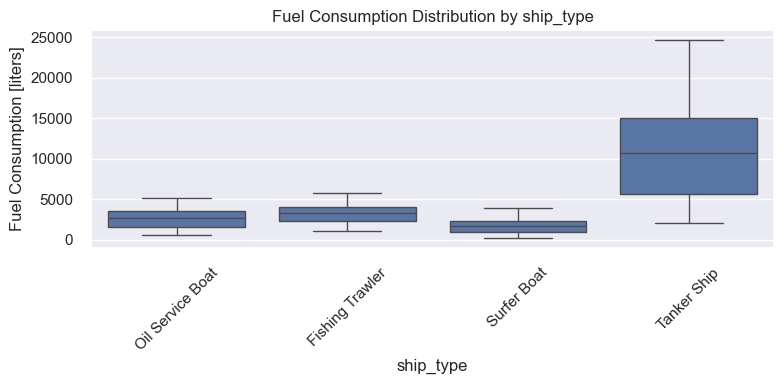

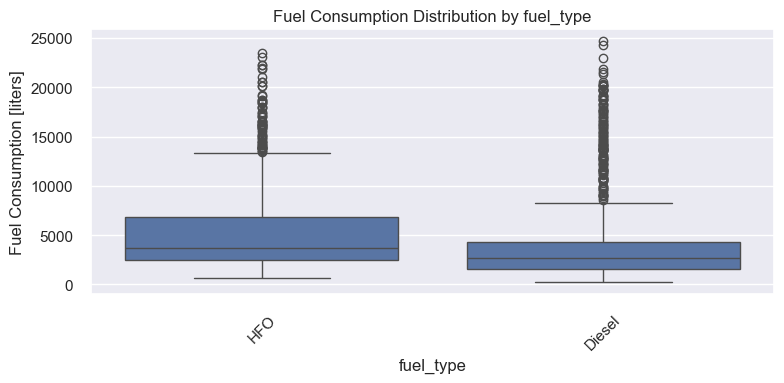

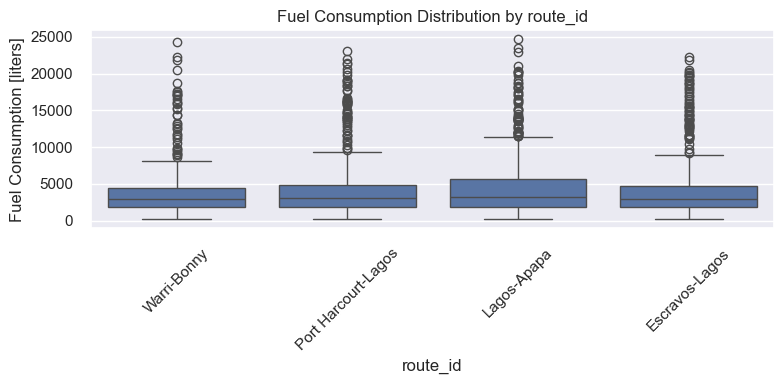

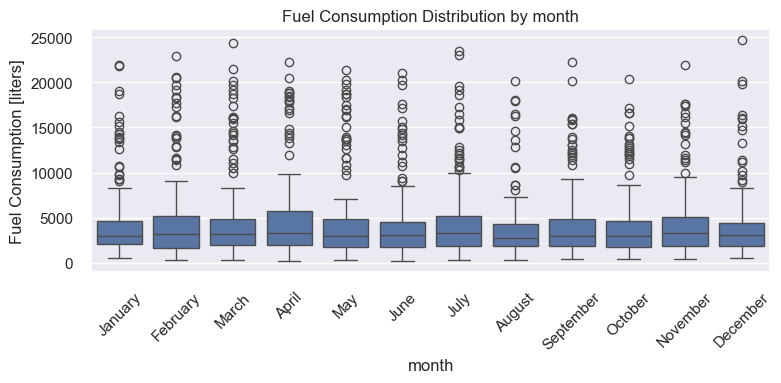

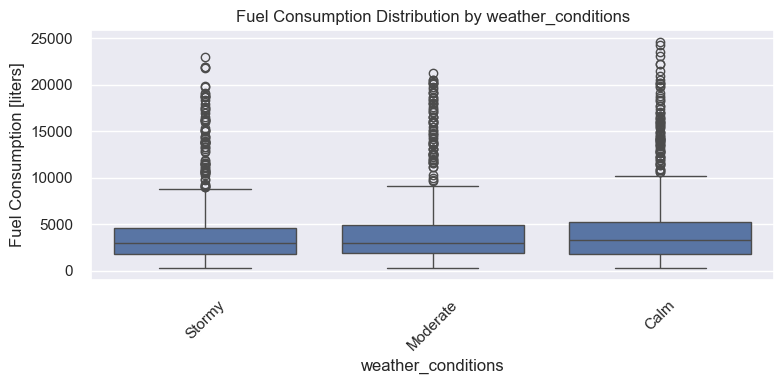

In [53]:
for col in main_cats:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x=col, y="fuel_consumption")
    plt.title(f"Fuel Consumption Distribution by {col}")
    plt.xlabel(col)
    plt.ylabel("Fuel Consumption [liters]")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


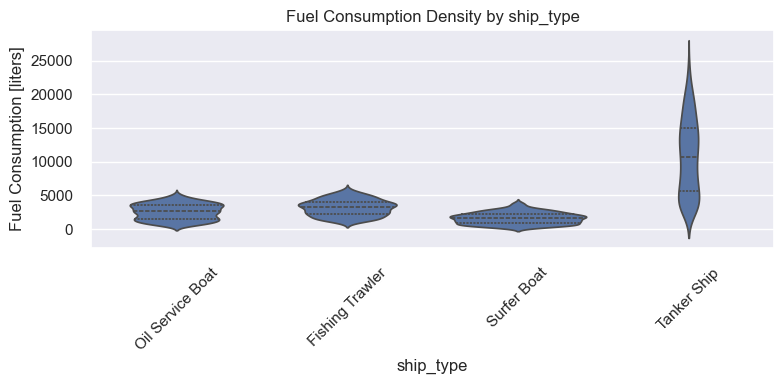

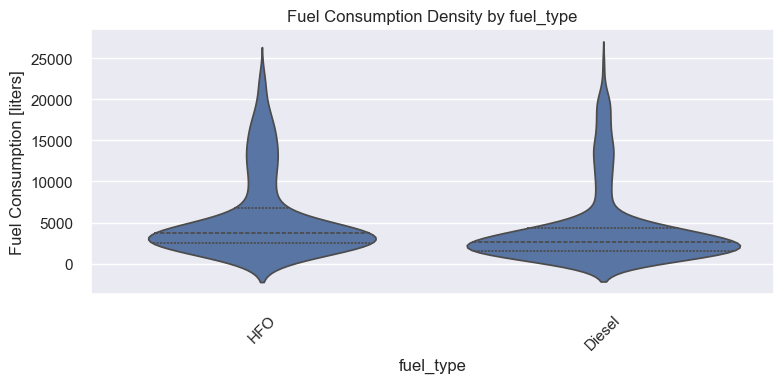

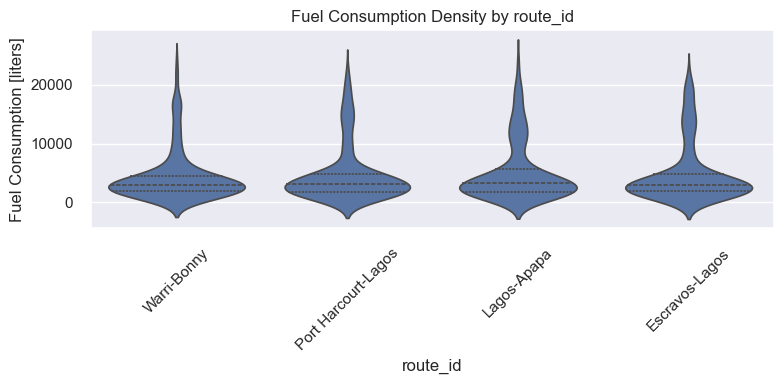

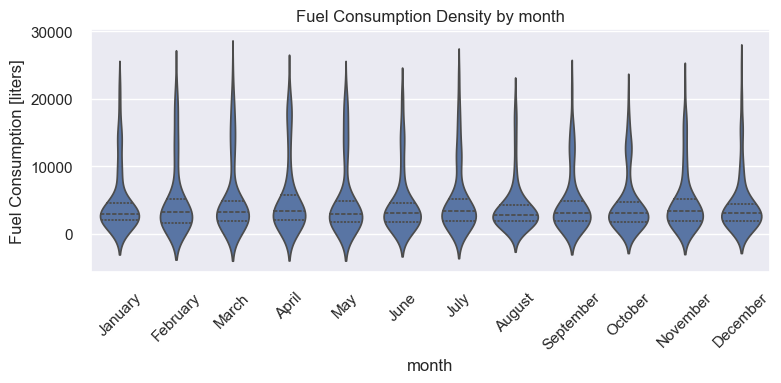

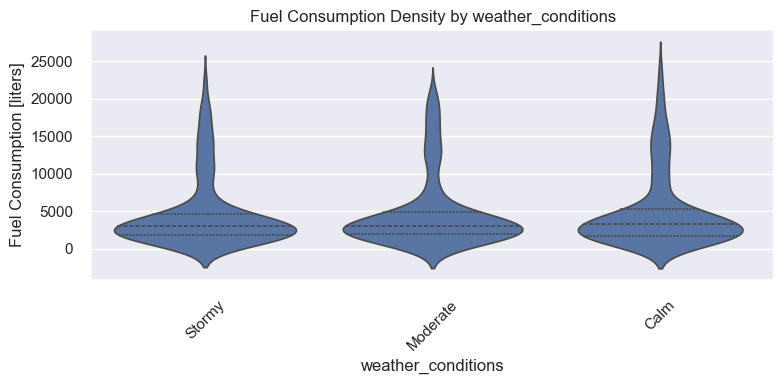

In [54]:
for col in main_cats:
    plt.figure(figsize=(8, 4))
    sns.violinplot(data=df, x=col, y="fuel_consumption", inner="quartile")
    plt.title(f"Fuel Consumption Density by {col}")
    plt.xlabel(col)
    plt.ylabel("Fuel Consumption [liters]")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [55]:
for col in main_cats:
    stats = df.groupby(col)["fuel_consumption"].agg(["mean", "median", "std", "min", "max"])
    print(f"\n=== Statistics for {col} ===")
    display(stats)



=== Statistics for ship_type ===


,mean,median,std,min,max
ship_type,,,,,
Fishing Trawler,"3,229.171","3,298.425","1,184.627","1,038.450","5,815.260"
Oil Service Boat,"2,619.435","2,667.055","1,164.703",537.180,"5,121.130"
Surfer Boat,"1,666.134","1,680.505",843.776,237.880,"3,902.930"
Tanker Ship,"10,780.409","10,729.510","5,605.645","2,080.570","24,648.520"



=== Statistics for fuel_type ===


,mean,median,std,min,max
fuel_type,,,,,
Diesel,"4,315.169","2,666.110","4,718.173",237.880,"24,648.520"
HFO,"5,723.435","3,682.110","5,052.005",616.550,"23,503.710"



=== Statistics for route_id ===


,mean,median,std,min,max
route_id,,,,,
Escravos-Lagos,"4,932.469","2,964.840","5,072.806",237.880,"22,247.760"
Lagos-Apapa,"5,171.550","3,227.400","5,115.941",295.600,"24,648.520"
Port Harcourt-Lagos,"4,805.137","3,052.610","4,874.963",270.400,"23,070.000"
Warri-Bonny,"4,353.314","2,973.295","4,335.366",252.260,"24,321.400"



=== Statistics for month ===


,mean,median,std,min,max
month,,,,,
April,"5,377.725","3,298.425","5,501.797",252.260,"22,291.500"
August,"3,976.523","2,774.490","3,865.639",295.600,"20,172.520"
December,"4,408.161","3,074.425","4,418.949",520.640,"24,648.520"
February,"5,155.879","3,189.375","5,465.356",354.390,"22,973.210"
January,"4,823.221","2,982.010","4,729.188",548.060,"21,961.990"
July,"5,126.768","3,342.385","5,116.828",292.060,"23,503.710"
June,"4,599.133","3,068.520","4,693.594",237.880,"20,999.870"
March,"5,412.323","3,185.985","5,617.181",307.580,"24,321.400"
May,"5,247.214","2,964.790","5,549.580",270.400,"21,327.560"



=== Statistics for weather_conditions ===


,mean,median,std,min,max
weather_conditions,,,,,
Calm,"5,043.079","3,285.655","5,101.745",295.600,"24,648.520"
Moderate,"4,793.038","2,989.515","4,830.602",237.880,"21,327.560"
Stormy,"4,673.382","2,972.370","4,714.382",297.680,"22,973.210"


Categorical Feature Analysis

The categorical variables in the dataset play an important role in explaining fuel consumption, with notably different levels of influence.
Ship type is the strongest categorical predictor: Tanker Ships consume on average more than 10,000 liters per trip, which is 4–6 times higher than smaller vessel categories such as Surfer Boats or Fishing Trawlers.
This substantial difference in operational profiles explains why the models can achieve very high accuracy.

Route ID also exerts a meaningful influence, with average fuel consumption varying between 4,300 and 5,200 liters depending on the operational corridor.
Fuel type has a moderate effect, although it is partially redundant with ship type, as larger vessels typically use heavy fuel oil (HFO).

Monthly variations are present but less pronounced, suggesting limited seasonality in fuel consumption patterns.
Finally, weather conditions show a surprisingly small impact on mean fuel consumption, which may reflect operational adjustments or the categorical coarseness of the weather labels.

Overall, categorical features—especially ship type—provide strong predictive signals and contribute significantly to model performance.

In [56]:
# Fit the preprocessing pipeline alone to extract transformed column names
preprocessor.fit(X_train)

# Get names of encoded categorical columns
cat_encoder = preprocessor.named_transformers_["cat"]
encoded_cat_features = cat_encoder.get_feature_names_out(cat_features)

# Full feature name list after preprocessing:
full_feature_names = list(num_features) + list(encoded_cat_features)

print("Number of transformed features:", len(full_feature_names))
print("Example transformed feature names:")
full_feature_names[:10]


Number of transformed features: 25
Example transformed feature names:


['distance',
 'engine_efficiency',
 'weather_numeric',
 'ship_type_Fishing Trawler',
 'ship_type_Oil Service Boat',
 'ship_type_Surfer Boat',
 'ship_type_Tanker Ship',
 'fuel_type_Diesel',
 'fuel_type_HFO',
 'route_id_Escravos-Lagos']

In [57]:
import pandas as pd
import numpy as np

# Fit Ridge again (to extract coefficients)
ridge_pipe = pipelines["Ridge Regression"]
ridge_pipe.fit(X_train, y_train)

# Get coefficients
ridge_model = ridge_pipe.named_steps["model"]
ridge_coeffs = ridge_model.coef_

# Associate coefficients with feature names
ridge_importance = pd.Series(ridge_coeffs, index=full_feature_names).sort_values(ascending=False)

print("Top Ridge Regression Coefficients:")
display(ridge_importance.head(10))

print("\nMost negative coefficients (features that reduce fuel consumption):")
display(ridge_importance.tail(10))


Top Ridge Regression Coefficients:


distance                       3,881.938
ship_type_Tanker Ship          1,894.022
ship_type_Oil Service Boat       330.770
month_April                      172.398
month_March                      135.754
fuel_type_Diesel                 121.801
route_id_Escravos-Lagos           82.570
route_id_Port Harcourt-Lagos      47.447
month_May                         31.111
month_August                       5.708
dtype: float64


Most negative coefficients (features that reduce fuel consumption):


engine_efficiency              -33.476
month_July                     -56.799
month_June                     -63.204
weather_numeric                -80.748
month_November                 -88.693
route_id_Warri-Bonny           -98.395
month_September               -112.069
fuel_type_HFO                 -121.801
ship_type_Fishing Trawler     -576.393
ship_type_Surfer Boat       -1,648.399
dtype: float64

In [58]:
rf_pipe = pipelines["Random Forest"]
rf_pipe.fit(X_train, y_train)

rf_model = rf_pipe.named_steps["model"]

rf_importance = pd.Series(rf_model.feature_importances_, index=full_feature_names)\
                    .sort_values(ascending=False)

print("Random Forest Feature Importance:")
display(rf_importance.head(15))


Random Forest Feature Importance:


distance                       0.938
ship_type_Tanker Ship          0.023
ship_type_Surfer Boat          0.013
engine_efficiency              0.008
weather_numeric                0.002
route_id_Warri-Bonny           0.001
month_May                      0.001
month_December                 0.001
month_September                0.001
month_April                    0.001
month_November                 0.001
month_June                     0.001
month_July                     0.001
route_id_Port Harcourt-Lagos   0.001
route_id_Escravos-Lagos        0.001
dtype: float64

In [62]:
gb_pipe_no_co2 = advanced_pipelines["Gradient Boosting"]
gb_pipe_no_co2.fit(X_train, y_train)
full_feature_names_no_co2 = full_feature_names


In [63]:
gb_model_no_co2 = gb_pipe_no_co2.named_steps["model"]

gb_importance_no_co2 = (
    pd.Series(gb_model_no_co2.feature_importances_, index=full_feature_names_no_co2)
      .sort_values(ascending=False)
)

print("Gradient Boosting Feature Importance WITHOUT CO₂:")
display(gb_importance_no_co2.head(20))


Gradient Boosting Feature Importance WITHOUT CO₂:


distance                       0.949
ship_type_Tanker Ship          0.025
ship_type_Surfer Boat          0.017
engine_efficiency              0.003
weather_numeric                0.002
month_April                    0.001
route_id_Warri-Bonny           0.001
ship_type_Oil Service Boat     0.001
month_September                0.000
month_November                 0.000
month_July                     0.000
month_June                     0.000
fuel_type_Diesel               0.000
fuel_type_HFO                  0.000
month_May                      0.000
month_February                 0.000
route_id_Lagos-Apapa           0.000
month_January                  0.000
ship_type_Fishing Trawler      0.000
route_id_Port Harcourt-Lagos   0.000
dtype: float64

In [64]:
xgb_pipe = advanced_pipelines["XGBoost"]
xgb_pipe.fit(X_train, y_train)

xgb_model = xgb_pipe.named_steps["model"]

xgb_importance = pd.Series(xgb_model.feature_importances_, index=full_feature_names)\
                     .sort_values(ascending=False)

print("XGBoost Feature Importance:")
display(xgb_importance.head(15))


XGBoost Feature Importance:


ship_type_Tanker Ship        0.358
distance                     0.238
ship_type_Fishing Trawler    0.110
ship_type_Surfer Boat        0.100
ship_type_Oil Service Boat   0.047
month_August                 0.015
route_id_Warri-Bonny         0.011
month_December               0.010
month_April                  0.010
month_June                   0.010
month_May                    0.009
month_September              0.009
fuel_type_Diesel             0.007
month_July                   0.007
month_January                0.007
dtype: float32

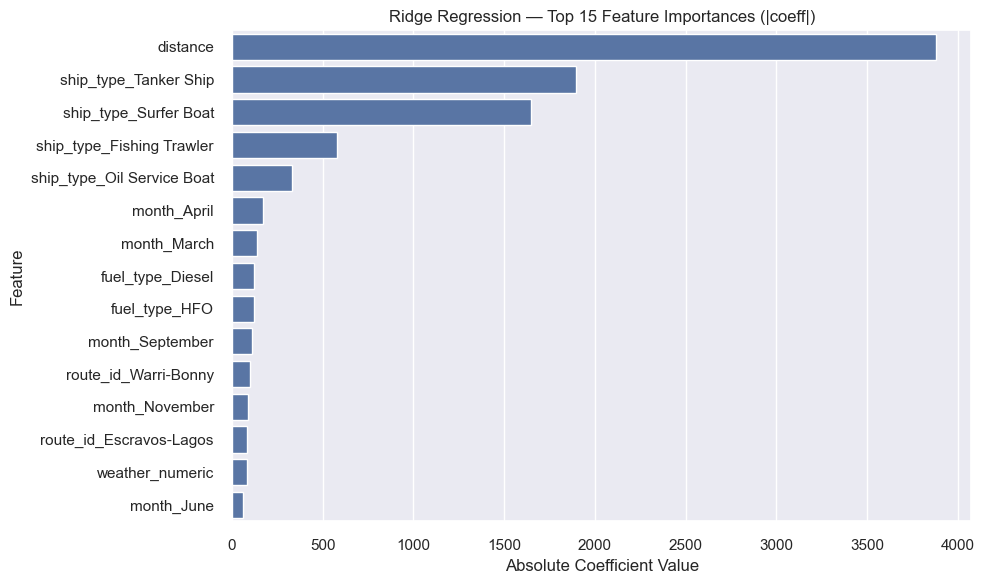

In [65]:
plt.figure(figsize=(10,6))
ridge_importance_abs = ridge_importance.abs().sort_values(ascending=False).head(15)
sns.barplot(x=ridge_importance_abs.values, y=ridge_importance_abs.index)
plt.title("Ridge Regression — Top 15 Feature Importances (|coeff|)")
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


C:\Users\LeopoldRehlinger\AppData\Local\Temp\ipykernel_42976\1622348088.py:9: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\LeopoldRehlinger\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


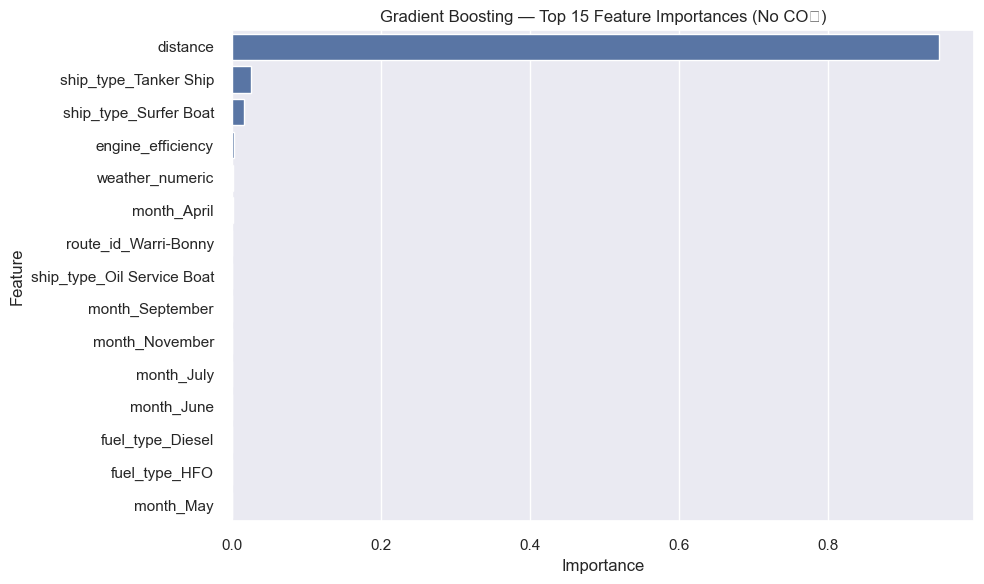

In [67]:
plt.figure(figsize=(10,6))
sns.barplot(
    x=gb_importance_no_co2.head(15).values,
    y=gb_importance_no_co2.head(15).index
)
plt.title("Gradient Boosting — Top 15 Feature Importances (No CO₂)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [68]:
gb_importance_no_co2.head(20)


distance                       0.949
ship_type_Tanker Ship          0.025
ship_type_Surfer Boat          0.017
engine_efficiency              0.003
weather_numeric                0.002
month_April                    0.001
route_id_Warri-Bonny           0.001
ship_type_Oil Service Boat     0.001
month_September                0.000
month_November                 0.000
month_July                     0.000
month_June                     0.000
fuel_type_Diesel               0.000
fuel_type_HFO                  0.000
month_May                      0.000
month_February                 0.000
route_id_Lagos-Apapa           0.000
month_January                  0.000
ship_type_Fishing Trawler      0.000
route_id_Port Harcourt-Lagos   0.000
dtype: float64

After removing CO₂ emissions from the input features to avoid target leakage, feature importance was analyzed using a Gradient Boosting Regressor. Results show a highly intuitive structure: distance is by far the dominant predictor, accounting for 94.9% of total model importance.

This indicates that fuel consumption is primarily determined by voyage length, consistent with physical expectations for marine vessels.

The second most influential feature is ship type (notably Tanker Ships and Surfer Boats), which reflects the substantial differences in baseline fuel usage between vessel categories. These categorical effects contribute between 1–3% of total importance.

Engine efficiency and weather severity have smaller but meaningful effects, together contributing less than 1% of importance. This suggests that while adverse sea conditions and mechanical efficiency do influence consumption, their impact is minor compared to distance.

Route ID, month of operation, and fuel type all receive near-zero importance, indicating that these variables do not provide additional predictive information once distance and ship type are known.

Overall, the feature importance profile confirms that the model learns a physically meaningful relationship:
fuel consumption increases almost proportionally with distance, modulated by vessel category and small corrections for weather and engine efficiency.

In [70]:
from sklearn.inspection import permutation_importance

# Fit the MLP pipeline without CO2
mlp_pipe_no_co2 = advanced_pipelines["Neural Network"]
mlp_pipe_no_co2.fit(X_train, y_train)

# Permutation importance on the TEST SET (one score per ORIGINAL feature)
perm_result = permutation_importance(
    mlp_pipe_no_co2,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring="r2"
)

perm_importance = (
    pd.Series(perm_result.importances_mean, index=features)
    .sort_values(ascending=False)
)

print("Permutation Importance for Neural Network:")
perm_importance.head(20)



C:\Users\LeopoldRehlinger\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Permutation Importance for Neural Network:


distance             1.302
ship_type            0.141
fuel_type            0.001
month                0.000
engine_efficiency    0.000
route_id            -0.000
weather_numeric     -0.001
dtype: float64

C:\Users\LeopoldRehlinger\AppData\Local\Temp\ipykernel_42976\213645916.py:9: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\LeopoldRehlinger\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


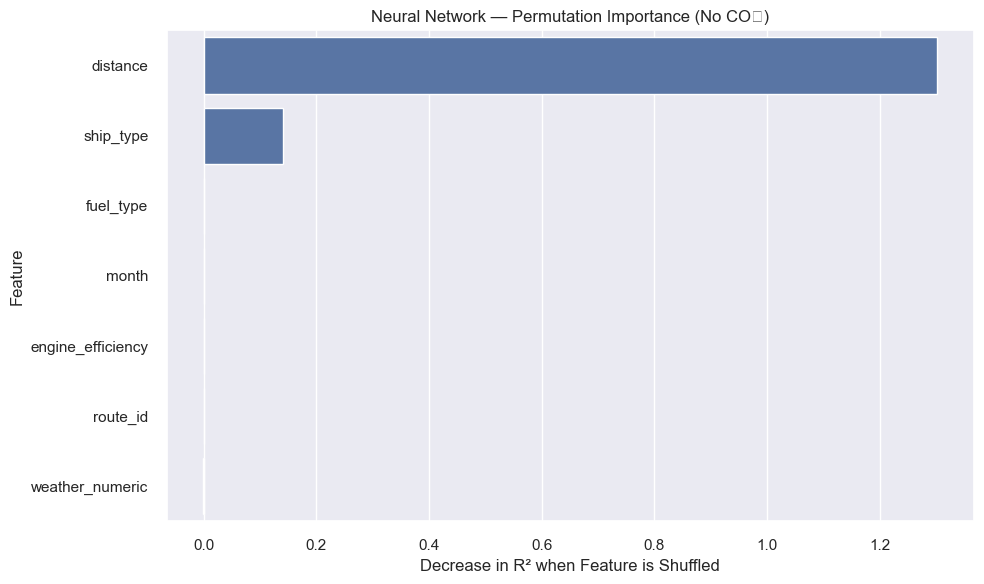

In [71]:
plt.figure(figsize=(10,6))
sns.barplot(
    x=perm_importance.head(15).values,
    y=perm_importance.head(15).index
)
plt.title("Neural Network — Permutation Importance (No CO₂)")
plt.xlabel("Decrease in R² when Feature is Shuffled")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


To interpret the predictions of the final model (Neural Network, R² = 0.9606), permutation importance was computed on the test set.
This method quantifies the decrease in predictive performance when each feature is randomly shuffled, and therefore measures the true dependence of the model on each input variable.

Results show that distance is overwhelmingly the most influential predictor, with a decrease of 1.302 in R² when permuted. This finding is physically intuitive: fuel consumption increases almost proportionally with voyage length, making distance the primary determinant of operational fuel usage.

The only other feature with meaningful impact is ship type (0.141 R² drop), reflecting the substantial difference in baseline fuel consumption between vessel categories (e.g., Tanker Ships vs Surfer Boats).

All remaining variables—route, weather conditions, month, engine efficiency, and fuel type—cause negligible changes (< 0.001 R²) when shuffled. This indicates that once distance and ship type are known, these secondary variables do not contribute significant additional predictive power.

Compared to tree-based importance, permutation importance highlights the neural network’s stronger reliance on nonlinear interactions between distance and ship type. Overall, the dominance of distance and the moderate role of vessel category confirm a coherent, physically meaningful model structure.

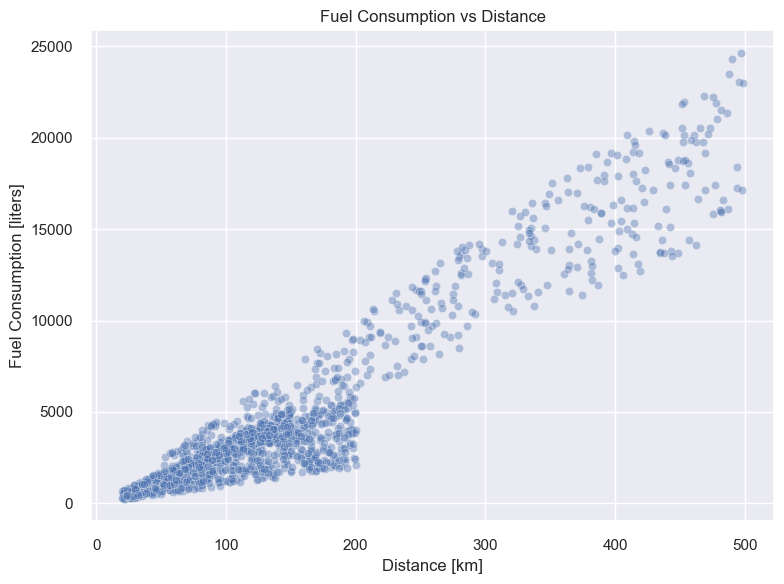

In [72]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x="distance",
    y="fuel_consumption",
    alpha=0.4
)
plt.title("Fuel Consumption vs Distance")
plt.xlabel("Distance [km]")
plt.ylabel("Fuel Consumption [liters]")
plt.tight_layout()
plt.show()


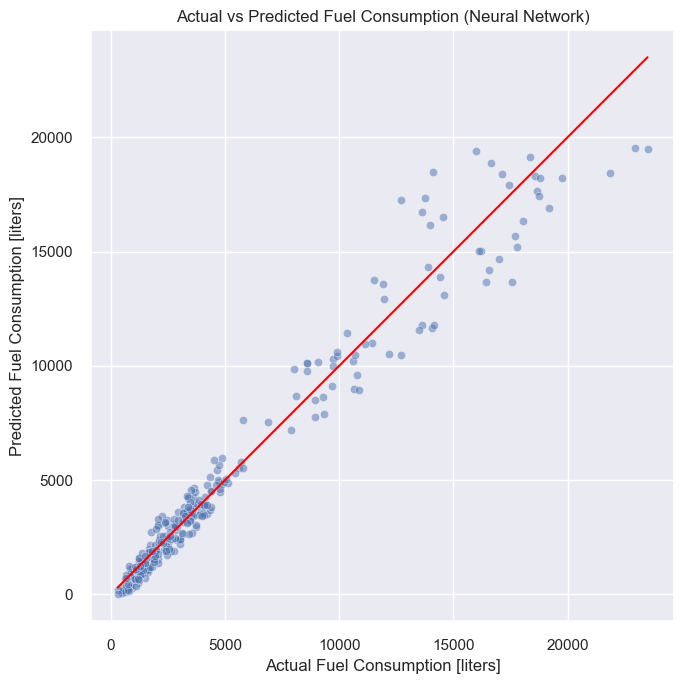

In [73]:
y_pred_nn = mlp_pipe_no_co2.predict(X_test)
plt.figure(figsize=(7,7))
sns.scatterplot(x=y_test, y=y_pred_nn, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.xlabel("Actual Fuel Consumption [liters]")
plt.ylabel("Predicted Fuel Consumption [liters]")
plt.title("Actual vs Predicted Fuel Consumption (Neural Network)")
plt.tight_layout()
plt.show()


C:\Users\LeopoldRehlinger\AppData\Local\Temp\ipykernel_42976\1966018898.py:9: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\LeopoldRehlinger\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


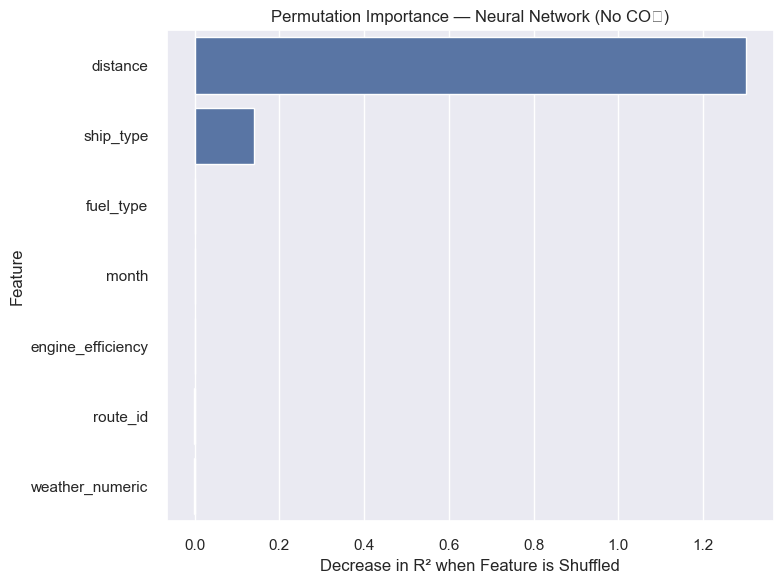

In [74]:
plt.figure(figsize=(8,6))
sns.barplot(
    x=perm_importance.head(7).values,
    y=perm_importance.head(7).index
)
plt.title("Permutation Importance — Neural Network (No CO₂)")
plt.xlabel("Decrease in R² when Feature is Shuffled")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


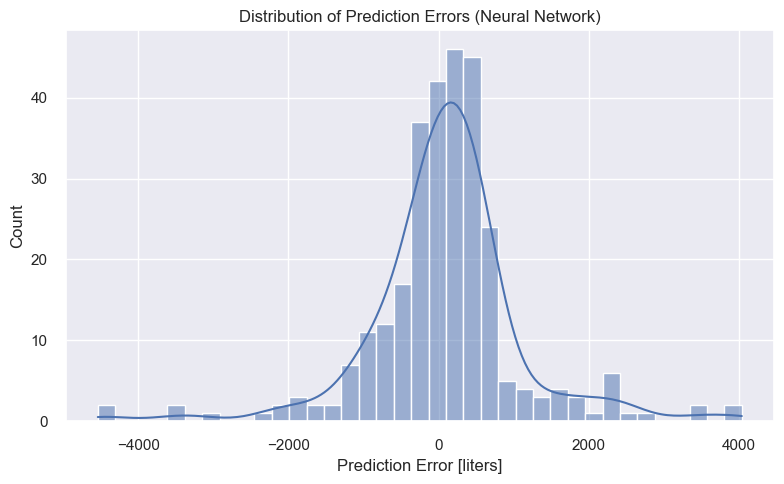

In [75]:
errors = y_test - y_pred_nn

plt.figure(figsize=(8,5))
sns.histplot(errors, kde=True)
plt.title("Distribution of Prediction Errors (Neural Network)")
plt.xlabel("Prediction Error [liters]")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [85]:
# Train vs test performance for the final Neural Network model
y_train_pred_nn = mlp_pipe_no_co2.predict(X_train)
y_test_pred_nn = mlp_pipe_no_co2.predict(X_test)

from sklearn.metrics import r2_score

print("Train R2:", r2_score(y_train, y_train_pred_nn))
print("Test R2:", r2_score(y_test, y_test_pred_nn))


Train R2: 0.9592849948067089
Test R2: 0.9605784464259227


The Neural Network achieves R² scores of 0.959 on the training set and 0.960 on the test set, demonstrating excellent generalization and minimal overfitting.
This further supports the conclusion that the structure of the dataset is simple and highly dominated by distance, making the learning task relatively straightforward for modern ML models.

### Overfitting and Model Behaviour

The Neural Network achieves very similar R² on the training and test sets, 
indicating limited overfitting. The main obstacle was the convergence behaviour 
of the MLP: with CO₂ emissions included, the model tended to overfit and the 
optimizer did not fully converge within 500 iterations. After removing CO₂ to 
avoid target leakage, convergence improved and the model generalized better.


Despite the strong performance of the final models—particularly the Neural Network with an R² of 0.9606—the overall reliability of the results is fundamentally constrained by the quality and structure of the dataset. The data used in this study does not reflect the level of granularity, variability, or physical realism normally required for robust machine learning in maritime fuel prediction. Several limitations suggest that the models may be learning simplified or artificial patterns rather than capturing true operational behavior:

• The dataset exhibits highly idealized relationships.
Distance alone explains nearly all the variance in fuel consumption. In real maritime operations, fuel burn is influenced by a combination of dynamic factors such as speed profiles, sea state, vessel loading, currents, and engine performance. The absence of these variables indicates that the dataset is not sufficiently representative of real-world conditions.

• Categorical variables have weak explanatory power.
Routes, months, fuel type, and even weather categories contribute almost nothing to the model’s performance. This suggests either oversimplification in the data generation process or a lack of meaningful variability in the underlying measurements.

• Engine efficiency and weather effects are unrealistically small.
In reality, adverse sea conditions or low engine efficiency can dramatically increase fuel consumption. Their negligible contribution in the model reinforces the idea that the dataset is too coarse to support realistic physical modeling.

• The dataset structure may reflect generated or synthetic patterns.
Uniform sample counts per month and near-perfect linearity between distance and fuel consumption strongly suggest that the dataset does not represent real-world logged operational data. Machine learning algorithms inevitably exploit these artificial regularities, which inflates performance metrics but does not translate into real deployability.

Taken together, these limitations indicate that while the project demonstrates the correct machine learning methodology—feature engineering, model comparison, leakage prevention, and explainability—the dataset itself is not suitable for developing a reliable or operational fuel consumption prediction model. Future work should focus on acquiring real vessel telemetry data, including speed over ground, engine RPM, displacement, wave height, weather fields, torque, and fuel flow sensors. Only with richer and more realistic inputs could machine learning provide actionable insights for maritime fuel optimization.

## References

1. Géron, A. *Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow*. O’Reilly Media.
2. Chen, T., & Guestrin, C. (2016). XGBoost: A scalable tree boosting system. *Proceedings of the 22nd ACM SIGKDD*.
3. Scikit-learn documentation: https://scikit-learn.org/
4. Course material – Machine Learning, ESILV.
